In [ ]:
! pip install optuna textstat category_encoders
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

In [ ]:
! unzip Data.zip

Archive:  Data.zip
  inflating: Data/power.csv          
  inflating: Data/text.csv           


In [ ]:
import os, random, optuna, textstat
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas_profiling import ProfileReport

from scipy.stats import mode
from sklearn.model_selection import cross_validate, KFold, RepeatedKFold, train_test_split
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, balanced_accuracy_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import NearestNeighbors, LocalOutlierFactor
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.base import TransformerMixin

import category_encoders as ce

import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor, early_stopping, Dataset

import seaborn as sns
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

In [1]:
! gdown "1d0XpolF_YMrXX_Wib6lMZVQMgBt2bpc0"

Downloading...
From: https://drive.google.com/uc?id=1d0XpolF_YMrXX_Wib6lMZVQMgBt2bpc0
To: /content/power.csv
100% 14.2M/14.2M [00:00<00:00, 121MB/s] 


In [ ]:
'''Set dataset directory'''
ROOT_DIR = "/content/Data"

# 1. Exploratory Data Analysis
- look at the dataset basics (size of the data, data types, look at a few examples etc.)
- look for any missing data
- look at target value
- look for any outliers in the data

## 1(a) Profile the dataset

In [ ]:
df = pd.read_csv(os.path.join(ROOT_DIR, "power.csv"))

display(df.head())

,id,obs_day,obs_hour,obs_minute,C_motion,fw_motion,faucet_hole,vap_pressure,vap_enth,vap_pressure_div,vap_motion,fw_enth,vap_temp,output_gen
0,a563699ca2a601c6ac64aa29986a00a90fb42b48741695...,Saturday,5.0,46.0,361.486145,2542.801078,0.666879,24.138243,2788.168701,25.448248,2543.177002,1270.066040,603.834106,930.271729
1,91ab3eb3bcf6c8c1c5fe2da9ba671aa5a48c7369d9a50f...,Saturday,18.0,NaN,197.064667,1454.458144,NaN,12.702796,NaN,13.405114,1454.421021,1095.314453,500.178772,473.562103
2,7128c51c554735d6c81862684ad6005ae12d2edbcd4644...,Saturday,3.0,51.0,356.869232,2458.671690,0.678685,NaN,2784.910889,NaN,2456.578369,1262.656982,603.529663,904.269897
3,c8144b52e4f63014de0a0d8e1c629bf0b05cb2696cfc23...,Saturday,13.0,NaN,239.267517,1628.127295,0.679137,15.378051,2881.876709,16.252741,1626.861328,1148.203857,593.649658,597.799194
4,88d15a5b2df6692f23d105ff1ae82ae026be00c9271eef...,Friday,11.0,13.0,NaN,2621.829401,0.676403,24.517698,2787.063232,NaN,2621.653564,1280.567383,602.601501,950.284973


In [ ]:
print("df shape:", df.shape)

df shape: (72000, 14)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                72000 non-null  object 
 1   obs_day           64163 non-null  object 
 2   obs_hour          64030 non-null  float64
 3   obs_minute        64148 non-null  float64
 4   C_motion          64089 non-null  float64
 5   fw_motion         64088 non-null  float64
 6   faucet_hole       64085 non-null  float64
 7   vap_pressure      64069 non-null  float64
 8   vap_enth          64179 non-null  float64
 9   vap_pressure_div  64197 non-null  float64
 10  vap_motion        64108 non-null  float64
 11  fw_enth           64157 non-null  float64
 12  vap_temp          64112 non-null  float64
 13  output_gen        72000 non-null  float64
dtypes: float64(12), object(2)
memory usage: 7.7+ MB


In [ ]:
# ProfileReport(df)

From the initial dataset profiling:

## 1(b) look at the missing values
- look for any patterns in missing data
- look at some examples of missing data

In [ ]:
df.isna().sum()

id                     0
obs_day             7837
obs_hour            7970
obs_minute          7852
C_motion            7911
fw_motion           7912
faucet_hole         7915
vap_pressure        7931
vap_enth            7821
vap_pressure_div    7803
vap_motion          7892
fw_enth             7843
vap_temp            7888
output_gen             0
dtype: int64

## 1(c) Look at the target variable

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


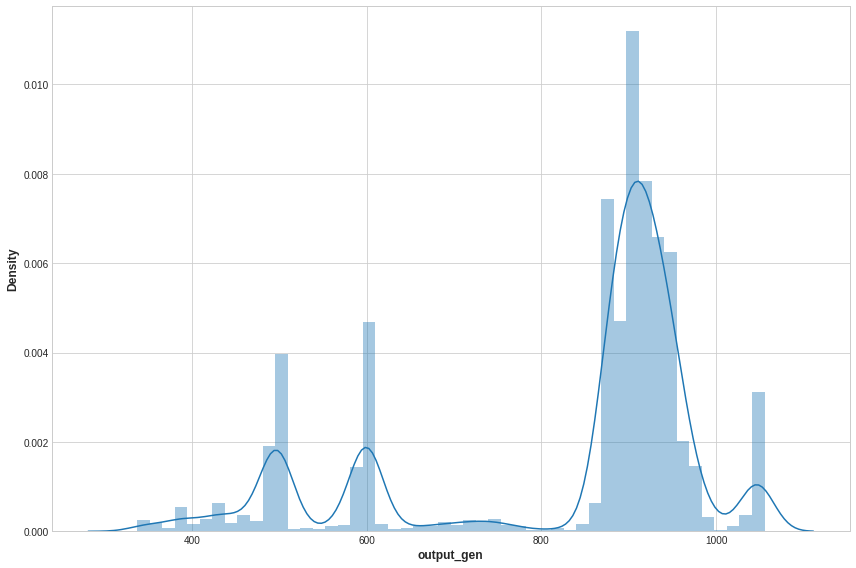

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df['output_gen'])

## 1(d) Look for Outliers

In [ ]:
df.describe()

,obs_hour,obs_minute,C_motion,fw_motion,faucet_hole,vap_pressure,vap_enth,vap_pressure_div,vap_motion,fw_enth,vap_temp,output_gen
count,64030.000000,64148.000000,64089.000000,64088.000000,64085.000000,64069.000000,64179.000000,64197.000000,64108.000000,64157.000000,64112.000000,72000.000000
mean,11.876573,29.331951,328.502440,2287.004777,0.670591,21.795922,2795.466210,23.003577,2309.925216,1230.615583,591.008818,829.873198
std,6.036525,17.297359,83.352896,448.204859,0.011327,5.545952,39.308843,5.832061,567.651009,255.842264,30.045351,174.256932
min,0.000000,0.000000,114.718575,1082.600626,0.602171,9.264307,2693.728271,9.766433,1085.054565,0.000000,466.858826,337.281067
25%,7.000000,14.000000,319.363281,2229.210642,0.662388,22.209974,2772.308716,23.490790,2333.306030,1248.165649,600.529053,841.792420
50%,12.000000,29.000000,350.142700,2461.767206,0.675311,23.302608,2787.034424,24.588034,2462.670654,1263.858887,602.362214,903.376618
75%,17.000000,44.000000,361.965179,2553.177473,0.678516,24.210491,2810.836670,25.518826,2555.305725,1274.751343,603.337692,932.125962
max,23.000000,59.000000,1698.141480,2932.372995,0.687707,109.212808,2933.161133,115.109406,11675.035156,5256.435548,608.553467,1055.392090


In [ ]:
variable ='fw_enth'

df[(df[variable] > df[variable].mean()+3*df[variable].std()) | (df[variable] < df[variable].mean()-3*df[variable].std())]

,id,obs_day,obs_hour,obs_minute,C_motion,fw_motion,faucet_hole,vap_pressure,vap_enth,vap_pressure_div,vap_motion,fw_enth,vap_temp,output_gen
6,0b4af6f80f2d50f189141a9d1b4d5d6d73496d19727968...,Saturday,19.0,41.0,NaN,1122.936791,0.685348,9.713677,2810.786621,10.249903,1124.073608,0.000000,470.612976,354.438171
23,6db4b051f6126d0e235416614bb76cea81a4ac97865302...,Saturday,19.0,50.0,115.297737,1092.684594,0.686894,NaN,NaN,9.766433,1089.438232,0.000000,467.456482,337.681793
52,410ec7c32f28c18a1bc09746b61270d6b3b63f597af19f...,NaN,19.0,29.0,147.272888,1245.945478,0.677985,10.881783,NaN,11.472459,1247.217163,0.000000,479.885040,390.639130
64,8d3c6be48ce73eb6cb74c43abca8b0607d6959464308c4...,Saturday,19.0,24.0,161.075119,1259.332895,0.682723,10.783157,2820.817383,11.332739,1258.081543,0.000000,474.267517,389.995331
146,054b2f7713395cfb5e22b60d423cf3fab7ca6ae88f0b59...,Saturday,19.0,NaN,167.772568,1263.774847,0.685979,10.764047,2807.850830,11.364876,1262.610474,0.000000,474.249390,390.580841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71707,e8b27803017799414f531b9ffa6be0def6e7f38ea58dc3...,Saturday,19.0,27.0,153.617294,NaN,0.661138,10.990579,2827.189941,11.555325,1236.697754,0.000000,NaN,385.335327
71799,c70f6e326bec5243efb3894452d2f7ed8a20c920006f2b...,Saturday,NaN,NaN,701.283326,2444.598294,0.671235,NaN,2791.875488,48.890893,4889.072754,2523.612060,602.939453,900.052246
71932,64cbc8484134848b4ee4c6c278d89574043f90f90e6914...,Saturday,19.0,30.0,141.461121,1234.800461,0.681422,10.779192,2850.148193,11.366927,1237.199707,0.000000,NaN,390.211029
71995,ce75db9da3358f6265f6623f4aec7865353c40690af2a6...,Saturday,19.0,24.0,161.449097,1258.899293,NaN,10.774268,2822.134277,11.326074,1256.907349,0.000000,NaN,389.339050


# 2. Import and Preprocess Data
- import some helper functions to do imputation and deal with data outliers
- use a function to do the data import and cleaning

In [ ]:
def simple_impute(df):
    '''
    Impute the numerical columns by the median value for each column and
    impute the categorical columns by the most frequent, or mode, for each column
    Note: one can easily switch in different imputers for each of the data types to something like kNN or iterative
    '''
    df= df.copy()
    # Impute missing values for numerical data
    # imp_num = IterativeImputer(estimator=ExtraTreesRegressor(), initial_strategy='median', max_iter=20)
    imp_num = SimpleImputer(strategy='median')
    numerical_df = df.select_dtypes("number")
    numerical_df = pd.DataFrame(data=imp_num.fit_transform(numerical_df), index=df.index, columns =numerical_df.columns)
    
    if df.select_dtypes("category").shape[1] >0:
        # Imput missing values for categorical data
        # imp_cat = IterativeImputer(estimator=ExtraTreesClassifier(), initial_strategy='most_frequent', max_iter=20)
        imp_cat = SimpleImputer(strategy='most_frequent')
        categorical_df = df.select_dtypes("category")
        enc = OrdinalEncoder()
        categorical_df = pd.DataFrame(data=enc.fit_transform(categorical_df), columns=categorical_df.columns)
        categorical_imputations = enc.inverse_transform(imp_cat.fit_transform(categorical_df))
        categorical_df = pd.DataFrame(data=categorical_imputations, index=df.index, columns =categorical_df.columns, dtype="category")
        return categorical_df.join(numerical_df).reindex(columns= df.columns)
    else:
        return numerical_df

In [ ]:
class ML_Impute(TransformerMixin):
  '''
  Impute missing values by treating the imputational as a machine learning problem. For numerical
  columns, we can treat the problem as a regression problem, and for categorical, a classification problem.
  For this method, we'll iterate through all of the columns with one column being the target variable
  and the others as being predictor variables
  '''

  def __init__(self, params={}):
    self.params = {}
    self.models = {}

  def fit(self, df):
    df = df.copy()
    # label encode categorical variables
    columns = df.columns.to_list()
    cat_cols = df.select_dtypes("category").columns.to_list()
    self.enc = OrdinalEncoder()
    df[cat_cols] = self.enc.fit_transform(df[cat_cols])
    
    # Randomized column selection
    for i in random.sample(range(len(df.columns)), len(df.columns)):
    
    # Starting with most null values to least
    # for i in np.argsort(-df.isnull().sum().values):
        column = columns[i]
        # Check to make sure there are null values that need to be imputed
        if not df[column].isnull().any():
            continue
        
        print("Creating Imputation Model for Column: {}".format(column))

        # Create train, test, and validation data using the null values of the column of interest
        X= df.loc[df[column].notnull()]
        y = X.pop(column)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1)
        
        X_test = df.loc[df[column].isnull()]
        _ = X_test.pop(column)
        
        # If we have more data, we use more estimators for the imputation model
        n_estimators = min(100, int(len(X_train) / 10))
        if column in cat_cols:
            model = LGBMClassifier(**self.params, verbose=-1, n_estimators=n_estimators)
        else:
            model = LGBMRegressor(**self.params, verbose=-1, n_estimators=n_estimators)
        
        model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],
                  callbacks = [early_stopping(min(20, int(len(X_train) / 10)))])
        print("Score of Column {} is {}".format(column, model.score(X,y)))
        self.models[column] = model 

  def transform(self, df):
    df = df.copy()
    
    # label encode categorical variables
    columns = df.columns.to_list()
    cat_cols = df.select_dtypes("category").columns.to_list()
    df[cat_cols] = self.enc.transform(df[cat_cols])

    for column in self.models.keys():
      X_test = df.loc[df[column].isnull()]
      _ = X_test.pop(column)
      model = self.models[column]
      preds =model.predict(X_test)
      m = df[column].isna()
      df.loc[m, column]  = preds.flatten()

    if len(cat_cols) >0:
      df[cat_cols] = self.enc.inverse_transform(df[cat_cols])

    return df

  def fit_transform(self, df):
    self.fit(df)
    df = self.transform(df)
    return df


In [ ]:
def cap_outliers(df, variables=[None]):
  df = df.copy()
  for variable in variables:
    upper_limit = df[variable].mean() + 3*df[variable].std()
    lower_limit = df[variable].mean() - 3*df[variable].std()
    df[variable] = np.where(df[variable]> upper_limit, upper_limit, np.where(
        df[variable]<lower_limit, lower_limit, df[variable]
    ))
  return df

In [ ]:
# Wrapper function to read in, encode and impute missing values for the data

def preprocess_data(df, cat_features=[None], outlier_features=[None]):
    
    # Specify categorical variables
    if cat_features is not None:
        for name in cat_features:
            df[name] = df[name].astype("category")
            # Add a None category for missing values
            if "None" not in df[name].cat.categories:
                df[name].cat.add_categories("None", inplace=True)

    # create test data set
    train, test = train_test_split(df, test_size=0.2)

    # Preprocessing
    imputer = ML_Impute()
    train = imputer.fit_transform(train)
    train = cap_outliers(train, outlier_features)

    test = imputer.transform(test)
    test = cap_outliers(test, outlier_features)


    return train, test

In [ ]:
#Now, load in and preprocess the data

df = pd.read_csv(os.path.join(ROOT_DIR, "power.csv"), index_col='id')
target_var = "output_gen"

train, test = load_data(df, cat_features = ['obs_day'], outlier_features=["vap_pressure_div", "vap_motion"])

# 3. Create a Baseline
- specify a baseline scoring function
- create a baseline model. 
  - For regression use `LGBMRegressor` and `scoring='neg_root_mean_squared_error'` and multiply the result by `-1`
  - For classification use `LGBMClassifier` and `scoring='balanced_accuracy'`

In [ ]:
def score_dataset(X, y, 
                  model=LGBMRegressor(n_estimators=1000, verbose=-1, random_state=42)
                 ):
    
    
    scores = cross_validate(
        model, X, y, cv=5, n_jobs=-1, scoring='neg_root_mean_squared_error', return_train_score=True
    )
    
    return {"Training":-1*np.mean(scores["train_score"]), "Validation":-1*np.mean(scores["test_score"])}

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

{'Training': 0.7159781843253301, 'Validation': 1.0687965707386546}

# 4. Featurize the Data
- remove uniformative features
- create interactions
- Binning
- Indicate Outliers
- Try different encodings for categorical variables

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
X = train.copy()
y = X.pop(target_var)
mi_scores = make_mi_scores(X, y)
mi_scores

vap_motion          3.018910
fw_enth             3.016559
vap_pressure_div    2.913655
fw_motion           2.894116
vap_pressure        2.860464
C_motion            2.397755
obs_hour            1.833721
vap_enth            1.612159
vap_temp            1.494131
faucet_hole         1.100363
obs_minute          0.965087
obs_day             0.349029
Name: MI Scores, dtype: float64

In [ ]:
# Try removing some of the uninformative features to see if that improves scores
uninformative_features = [
    'obs_minute',
    'obs_day'
]

X = train.copy()
y = X.pop(target_var)
X = X.loc[:,~X.columns.isin(uninformative_features)]
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

{'Training': 0.7474270564663286, 'Validation': 1.0974400597306795}

For mathematical transforms, try things like log transforms:

`X['feature'] = np.log1p(X['feature'])`

For interations try multiplying or dividing features, especially between levels
of a categorical feature and a continuous feature. Use subject matter expertise here

`df_new['A_B_interation'] = ce.OneHotEncoder().fit_transform(X['A']) * X['B']`

In [ ]:
def mathematical_transforms(df):
    X = pd.DataFrame(index=df.index)

    return X

def interactions(df):
    X = pd.DataFrame(index=df.index)

    return X

In [ ]:
X = train.copy()
y = X.pop(target_var)
#X = X.join(mathematical_transforms(X))
#X = X.join(interactions(X))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

{'Training': 0.7159781843253301, 'Validation': 1.0687965707386546}

Notes:

In [ ]:
def cluster_labels(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = ce.OneHotEncoder().fit_transform(X_scaled)
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / (X_scaled.std(axis=0)+0.000001)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    X_new = pd.DataFrame(index=X.index)
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    X_new["Cluster"] = X_new["Cluster"].astype("category")
    return X_new["Cluster"]


def cluster_distance(df, features, n_clusters=10):
    X = df.copy()
    X_scaled = X.loc[:, features]
    X_scaled = ce.OneHotEncoder().fit_transform(X_scaled)
    X_scaled = (X_scaled - X_scaled.mean(axis=0)) / (X_scaled.std(axis=0)+0.000001)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])], index=X.index
    )
    return X_cd

In [ ]:
vape = [
    'vap_pressure', 'vap_enth', 'vap_motion', 'vap_temp'
]

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = X.join(cluster_distance(X, vape, n_clusters=10))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = X.join(cluster_labels(X, vape, n_clusters=10))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

Notes:

In [ ]:
def flag_outliers(df):
  df = df.copy()
  df = ce.OneHotEncoder().fit_transform(df)
  clf = LocalOutlierFactor()
  df["Outlier"] = clf.fit_predict(df)
  return df["Outlier"]

In [ ]:
X = train.copy()
y = X.pop(target_var)
X = X.join(flag_outliers(X))
X = ce.OrdinalEncoder().fit_transform(X)

score_dataset(X, y)

{'Training': 0.712844519297834, 'Validation': 1.068740063638274}

Notes:

# 5. Finalize Features for Final Model

In [ ]:
def create_features(df, df_test=None):
    X = df.copy()
    
    if df_test is not None:
        X_test = df_test.copy()
        X = pd.concat([X, X_test])
        
    # Add in engineered features
    X = X.join(flag_outliers(X))
    X = ce.OrdinalEncoder().fit_transform(X)

    
    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)
    

    if df_test is not None:
        return X, X_test
    else:
        return X

In [ ]:
X = train.copy()
X_test = test.copy()
y = X.pop(target_var)
y_test = X_test.pop(target_var)

X, X_test = create_features(train, test)

In [ ]:
score_dataset(X, y)

{'Training': 0.30368537758738307, 'Validation': 0.5467700949212131}

# 6. Hyperparameter Tuning
- you need to specify the objective (i.e. `'regression'`, `'multiclass'` with '`num_class`', etc.) 

In [ ]:
def objective(trial, X, y):
    # Specify a search space using distributions across plausible values of hyperparameters.
    param = {
        "objective": "regression",
        "verbosity": -1,              
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 0, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
    }
    
    # Run LightGBM for the hyperparameter values
    lgbcv = lgb.cv(param,
                   lgb.Dataset(X, label=y),
                   folds= KFold(n_splits=5, shuffle=True),
                   verbose_eval=False,                   
                   early_stopping_rounds=10,                   
                   num_boost_round=100
                  )
    
    cv_score = lgbcv['l2-mean'][-1]
    
    # Return metric of interest
    return cv_score

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING) 
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X, y), timeout=300, n_trials=5) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: suggest_uniform has been depreca

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
print(study.best_params)

{'lambda_l1': 5.390038672183816e-06, 'lambda_l2': 0.07446235059068343, 'num_leaves': 170, 'feature_fraction': 0.7011501923001645, 'bagging_fraction': 0.3193119439092119, 'bagging_freq': 6, 'min_child_samples': 57}


In [ ]:
print(study.best_value**0.5)

0.7896119175885383


# 7. Fit final model and check predictions
- you need to specify the objective (i.e. `'regression'`, `'multiclass'` with '`num_class`', etc.) 

In [ ]:
preds = []
skf = RepeatedKFold(n_splits=3, n_repeats=2)

for fold_idx, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
    lgb_params = {
        'objective': 'regression',
        'verbose': -1,
        'n_estimators': 100,
        **study.best_params
    }
    model = lgb.train(lgb_params, lgb_train, valid_sets=lgb_eval, callbacks=[lgb.early_stopping(10)])

    y_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, y_pred, squared=False)
    print("Fold {} MSE Score: {}".format(fold_idx, score))
    print("----------------------")
    preds.append( model.predict(X_test))

In [ ]:
# Use average for ensembling of the labels

final_preds = np.mean(preds, axis=0)

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(16,8))
sns.distplot(y_test, ax=axs[0])
axs[0].set_title("Distribution of Test Target Variable")
sns.distplot(final_preds , ax=axs[1])
axs[1].set_title("Distribution of Predicted Target Variable")

In [ ]:
print("Test Accuracy: {}".format(mean_squared_error(y_test, final_preds, squared=False)))

Test Accuracy: 1.7575762131641304
